# Merge all the CSV files into a combined one
- Merge by `join`
- Delete the key
- Select

In [ ]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv('./data/application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('./data/application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('./data/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('./data/bureau_balance.csv', nrows=num_rows)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()
    return bureau


# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv('./data/previous_application.csv', nrows=num_rows)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    gc.collect()
    return prev


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('./data/POS_CASH_balance.csv', nrows=num_rows)
    gc.collect()
    return pos


# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('./data/installments_payments.csv', nrows=num_rows)
    gc.collect()
    return ins


# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('./data/credit_card_balance.csv', nrows=num_rows)
    gc.collect()
    return cc


# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified=False, debug=False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc', verbose=200, early_stopping_rounds=200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index=False)
    display_importances(feature_importance_df)
    return feature_importance_df


# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance",
                                                                                                   ascending=False)[
           :40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug=False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.merge(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
      prev = previous_applications(num_rows)
      print("Previous applications df shape:", prev.shape)
      df = df.merge(prev, how='left', on='SK_ID_CURR')
      del prev
      gc.collect()
    with timer("Process POS-CASH balance"):
      pos = pos_cash(num_rows)
      print("Pos-cash balance df shape:", pos.shape)
      df = df.merge(pos, how='left', on='SK_ID_CURR')
      del pos
      gc.collect()
    with timer("Process installments payments"):
      ins = installments_payments(num_rows)
      print("Installments payments df shape:", ins.shape)
      df = df.merge(ins, how='left', on='SK_ID_CURR')
      del ins
      gc.collect()
    with timer("Process credit card balance"):
      cc = credit_card_balance(num_rows)
      print("Credit card balance df shape:", cc.shape)
      df = df.merge(cc, how='left', on='SK_ID_CURR')
      del cc
      gc.collect()
    with timer("Run LightGBM with kfold"):
      df.to_csv('data_v1.csv')
      print(df)
        # df.to_csv('./data/final_training_data.csv', index=False)
        # feat_importance = kfold_lightgbm(df, num_folds=10, stratified=False, debug=debug)


if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        main()


Train samples: 3864, test samples: 3850
Bureau df shape: (21183, 19)
Process bureau and bureau_balance - done in 1s
Previous applications df shape: (21311, 38)
Process previous_applications - done in 0s
Pos-cash balance df shape: (53381, 8)
Process POS-CASH balance - done in 0s
Installments payments df shape: (98649, 8)
Process installments payments - done in 0s
Credit card balance df shape: (327123, 23)
Process credit card balance - done in 1s
       index  SK_ID_CURR  TARGET NAME_CONTRACT_TYPE_x  CODE_GENDER  \
0          0      100002     1.0           Cash loans            0   
1          1      100003     0.0           Cash loans            1   
2          2      100004     0.0      Revolving loans            0   
3          3      100006     0.0           Cash loans            1   
4          4      100007     0.0           Cash loans            0   
...      ...         ...     ...                  ...          ...   
32897   3846      127375     NaN           Cash loans        

In [ ]:
df = pd.read_csv('data_v1.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (129,130,141) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32902 entries, 0 to 32901
Data columns (total 220 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    Unnamed: 0                    int64  
 1    index                         int64  
 2    SK_ID_CURR                    int64  
 3    TARGET                        float64
 4    NAME_CONTRACT_TYPE_x          object 
 5    CODE_GENDER                   int64  
 6    FLAG_OWN_CAR                  int64  
 7    FLAG_OWN_REALTY               int64  
 8    CNT_CHILDREN                  int64  
 9    AMT_INCOME_TOTAL              float64
 10   AMT_CREDIT_x                  float64
 11   AMT_ANNUITY_x                 float64
 12   AMT_GOODS_PRICE_x             float64
 13   NAME_TYPE_SUITE_x             object 
 14   NAME_INCOME_TYPE              object 
 15   NAME_EDUCATION_TYPE           object 
 16   NAME_FAMILY_STATUS            object 
 17   NAME_HOUSING_TYPE             object 
 18   REGI

Catergorical columns:
- If the datatype is 'object', it must be catergorical feature
- Elif the datatype is 'int64', it may be catergorical feature
- If the datatype is 'float64', it may be catergorical feature

In [ ]:
# Firstly, the columns of 'object' dtype must be catergorical data 
catergoricial_column = ['NAME_CONTRACT_TYPE_x', 'NAME_TYPE_SUITE_x', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE',
       'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE',
       'EMERGENCYSTATE_MODE', 'CREDIT_ACTIVE', 'CREDIT_CURRENCY',
       'CREDIT_TYPE',
       'FLAG_LAST_APPL_PER_CONTRACT', 'NAME_CASH_LOAN_PURPOSE',
       'NAME_CONTRACT_STATUS_x', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON',
       'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY',
       'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE',
       'NAME_SELLER_INDUSTRY', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION',
       'NAME_CONTRACT_STATUS','CODE_GENDER',
       'FLAG_OWN_CAR','FLAG_OWN_REALTY','FLAG_EMP_PHONE',
       'FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','FLAG_DOCUMENT_3',
       'FLAG_DOCUMENT_5','FLAG_DOCUMENT_6','FLAG_DOCUMENT_8','NFLAG_INSURED_ON_APPROVAL','REGION_RATING_CLIENT','AMT_REQ_CREDIT_BUREAU_WEEK']
cat_df = df.loc[:,catergoricial_column]

In [ ]:
len(catergoricial_column)

45

In [ ]:
for col, val in cat_df.iteritems():
    if (cat_df[col].isnull().sum() / len(val) * 100) > 30:
        cat_df.drop(columns=col, inplace=True)
cal_col = cat_df.columns
len(cal_col)

23

Numerical features:

In [ ]:
float64_columns = df.select_dtypes(['float64']).columns
numerical_df = df.loc[:,float64_columns]

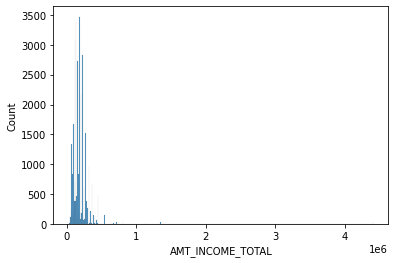

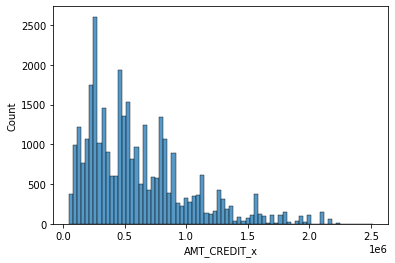

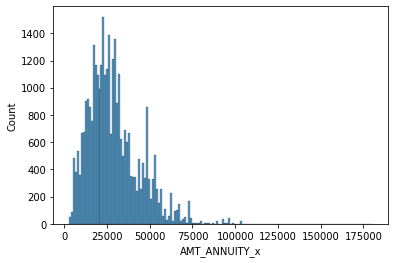

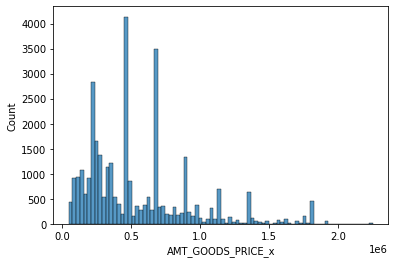

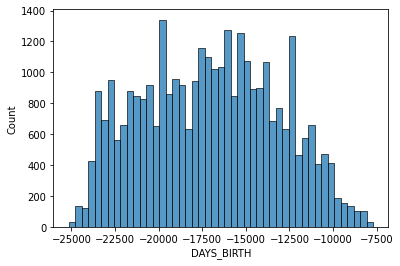

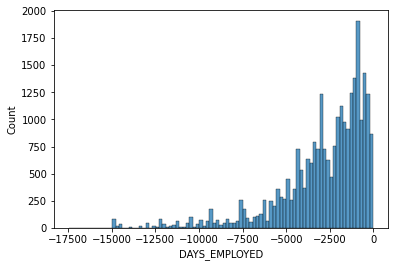

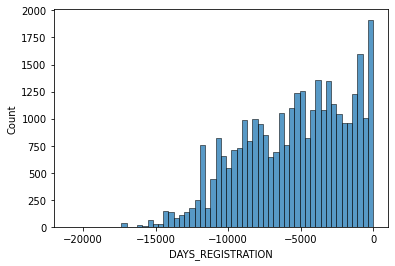

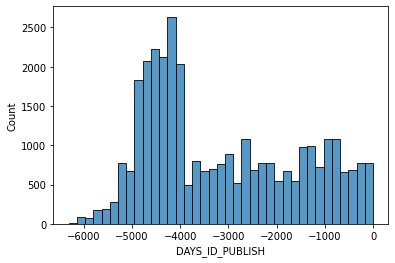

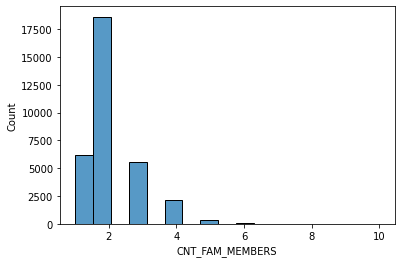

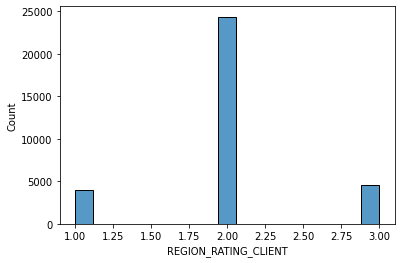

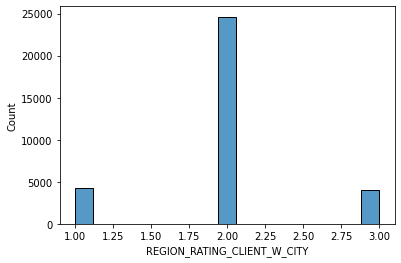

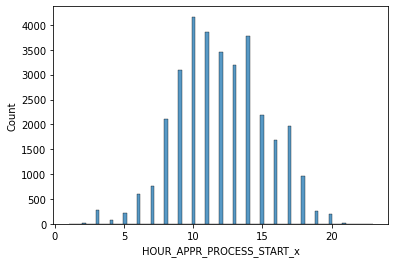

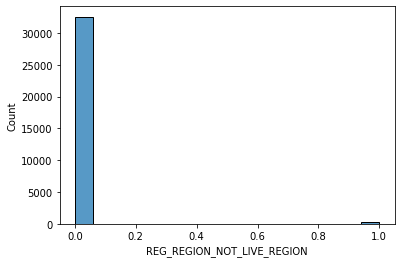

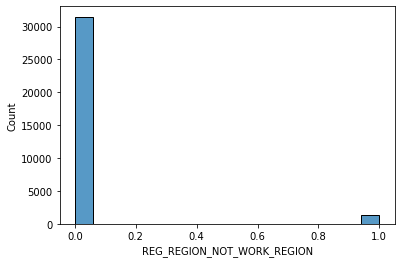

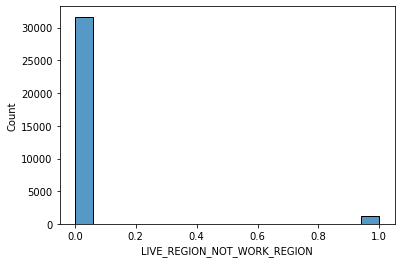

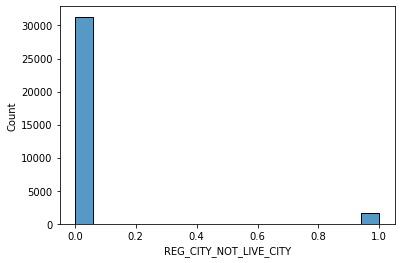

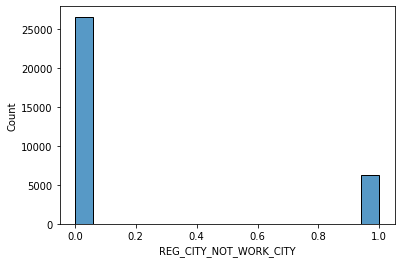

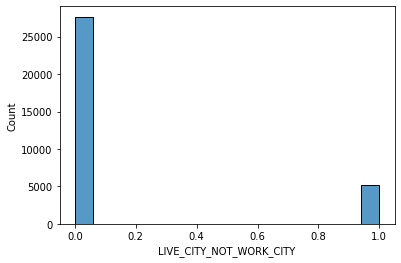

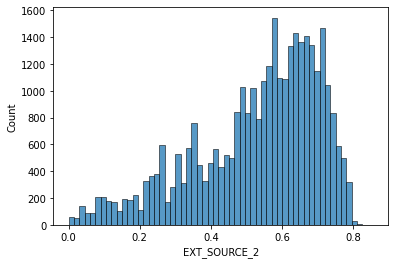

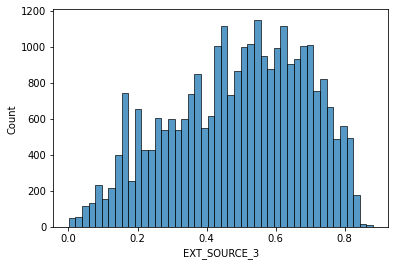

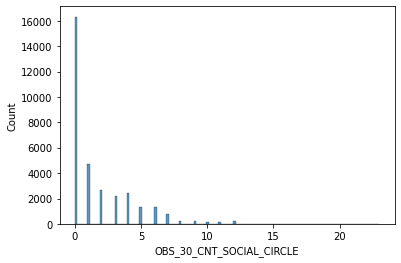

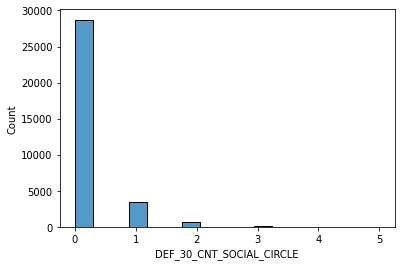

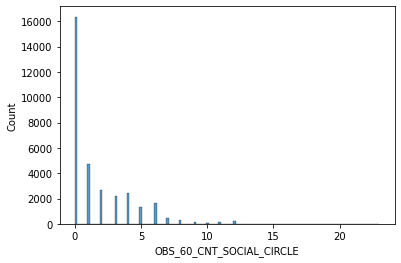

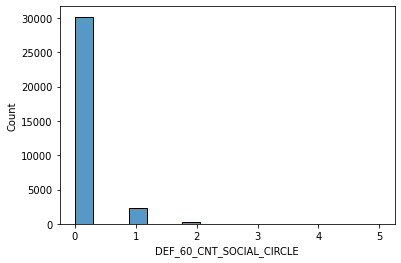

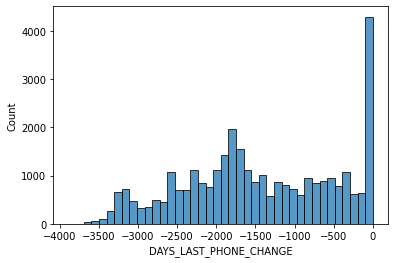

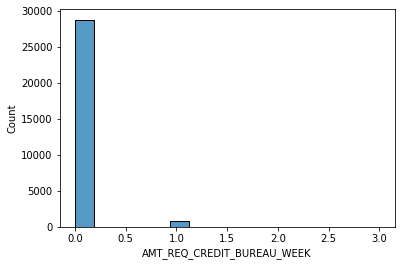

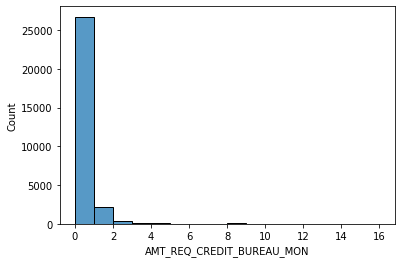

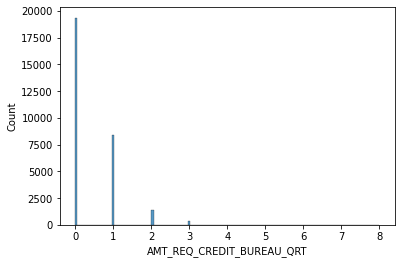

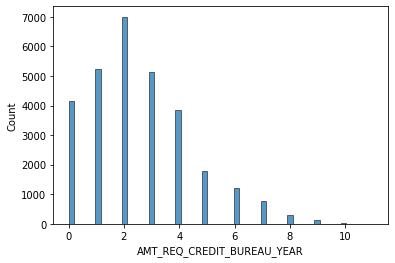

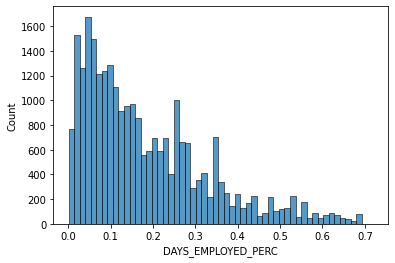

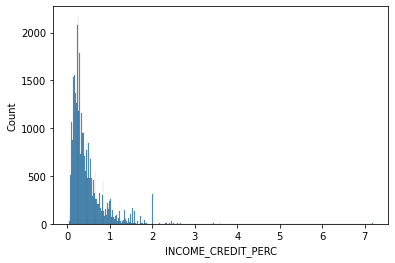

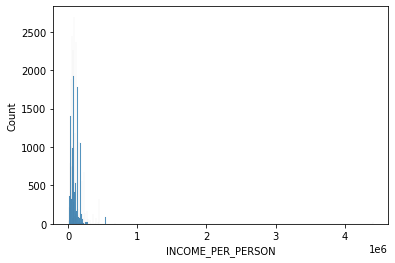

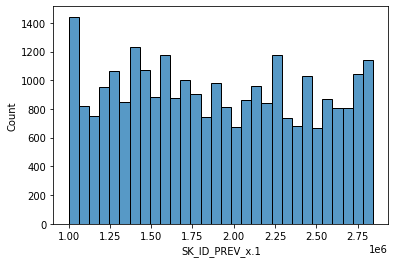

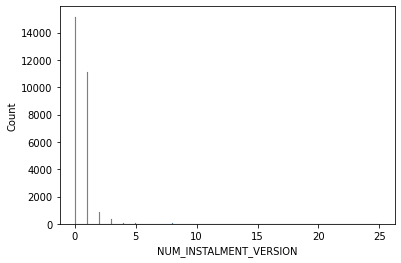

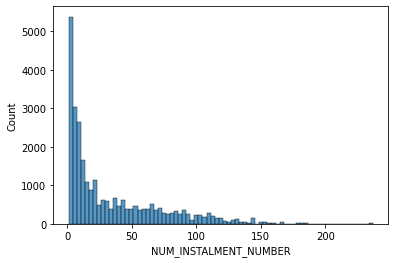

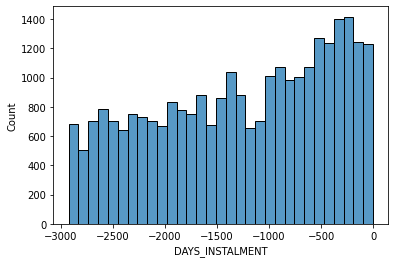

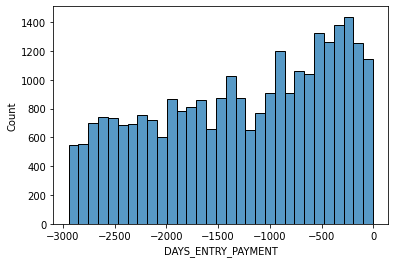

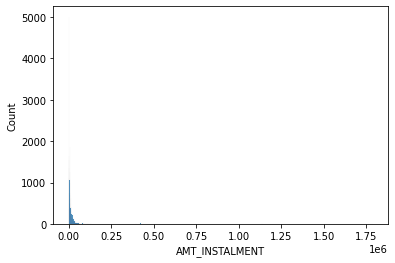

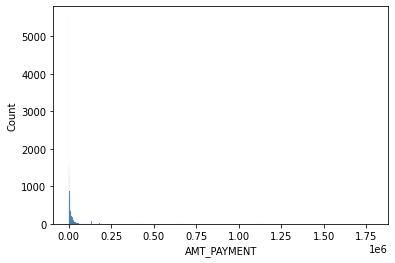

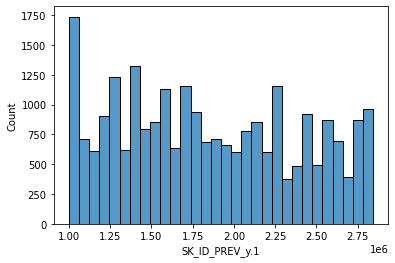

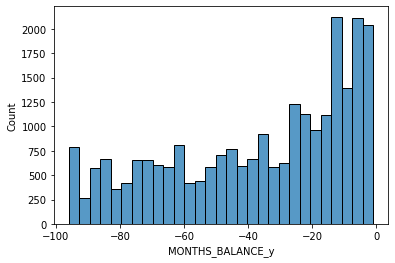

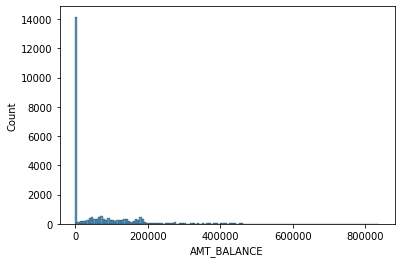

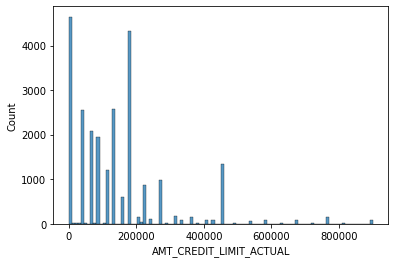

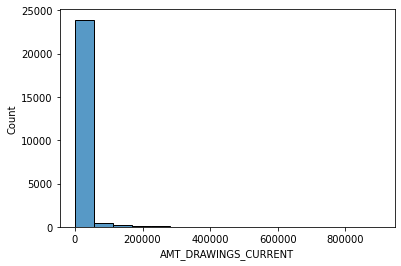

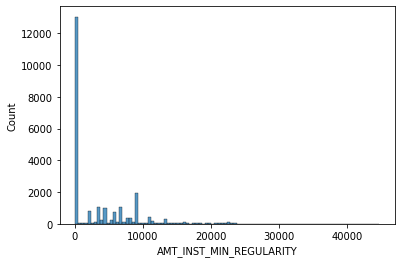

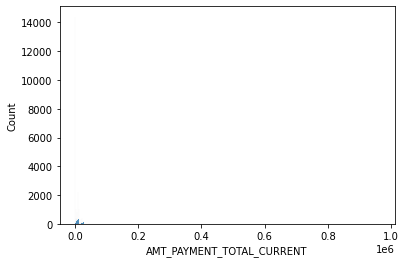

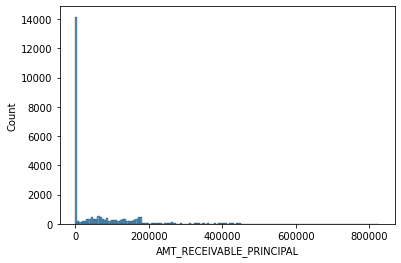

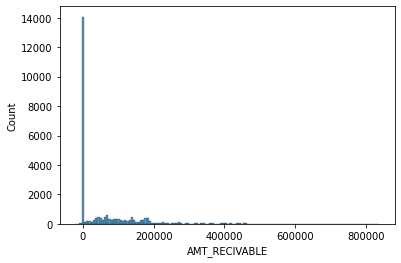

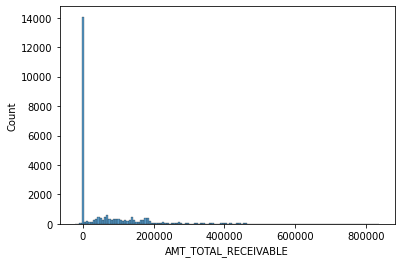

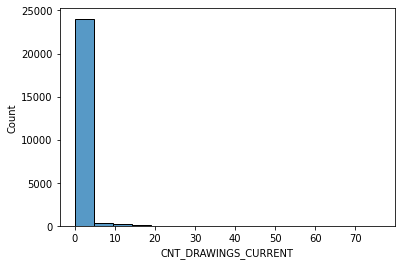

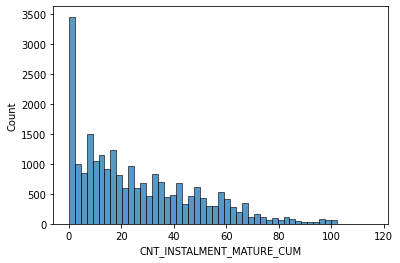

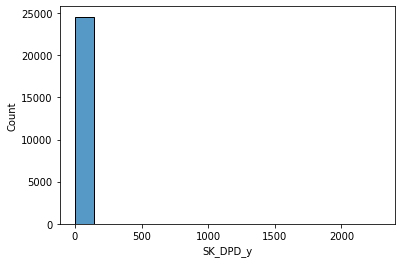

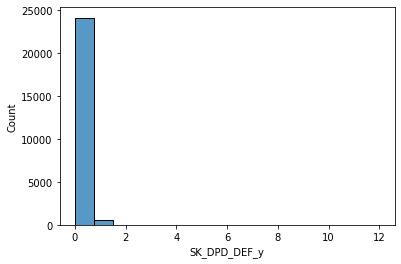

In [ ]:
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0.01)
constant_filter.fit(df[float64_columns])
new_f_list = []
without_constant_features = numerical_df[float64_columns].columns[constant_filter.get_support()]
numerical_df = numerical_df.loc[:,without_constant_features]
for col, val in numerical_df.iteritems():
    if (numerical_df[col].isnull().sum() / len(val) * 100) > 30:
        numerical_df.drop(columns=col, inplace=True)
for c in numerical_df.columns:
  if 'FLAG' not in c and c!= 'TARGET':
    new_f_list.append(c)
    if (len(numerical_df.loc[:,c].unique())>=3):
      sns.histplot(data=numerical_df,x=c)
      plt.show()

In [ ]:
numerical_columns = numerical_df.columns
len(numerical_columns)
numerical_columns

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x',
       'AMT_GOODS_PRICE_x', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_x',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_EMPLOYED_PERC',
       'INCOME_CREDIT_PERC', 'INC

In [ ]:
numerical_df.REG_CITY_NOT_LIVE_CITY.unique()

array([ 0.,  1., nan])

In [ ]:
len(new_f_list)

123

# The num and cal columns are:

In [ ]:
cat_col=['NAME_CONTRACT_TYPE_x', 'NAME_TYPE_SUITE_x', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'WEEKDAY_APPR_PROCESS_START_x', 'ORGANIZATION_TYPE',
       'NAME_CONTRACT_STATUS', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_5',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_8', 'REGION_RATING_CLIENT', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY','LIVE_REGION_NOT_WORK_REGION','AMT_REQ_CREDIT_BUREAU_WEEK']
num_col = ['AMT_INCOME_TOTAL', 'AMT_CREDIT_x', 'AMT_ANNUITY_x',
       'AMT_GOODS_PRICE_x', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
       'DAYS_ID_PUBLISH', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START_x',
       'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'DAYS_EMPLOYED_PERC',
       'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON',
       'NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT',
       'DAYS_ENTRY_PAYMENT', 'AMT_INSTALMENT', 'AMT_PAYMENT', 'SK_ID_PREV_y.1',
       'MONTHS_BALANCE_y', 'AMT_BALANCE', 'AMT_CREDIT_LIMIT_ACTUAL',
       'AMT_DRAWINGS_CURRENT', 'AMT_INST_MIN_REGULARITY',
       'AMT_PAYMENT_TOTAL_CURRENT', 'AMT_RECEIVABLE_PRINCIPAL',
       'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE', 'CNT_DRAWINGS_CURRENT',
       'CNT_INSTALMENT_MATURE_CUM']
x_cols = cat_col + num_col
y_cols = ['TARGET']
all_col = x_cols + y_cols
data = df.loc[:,all_col]

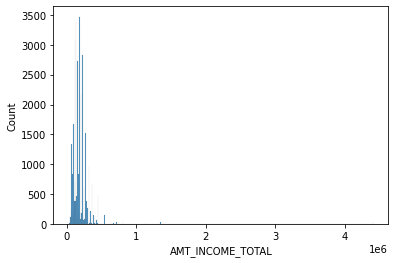

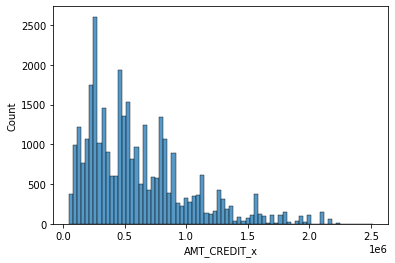

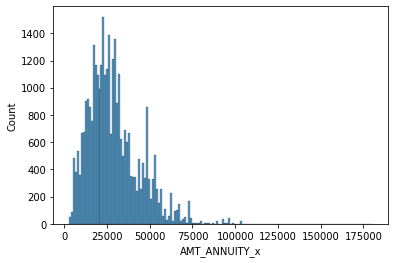

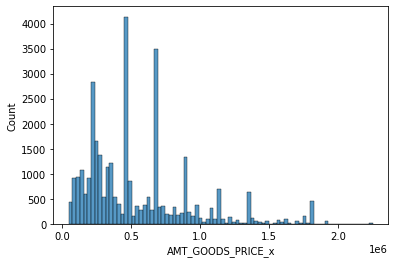

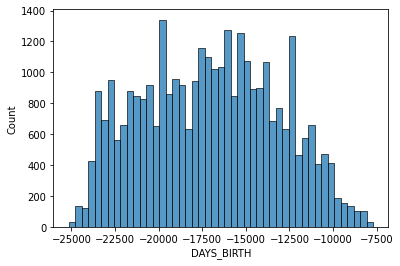

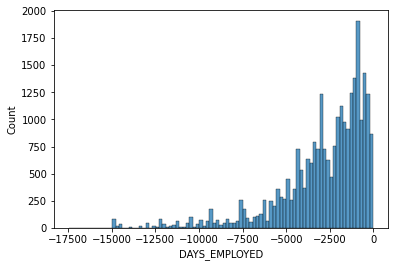

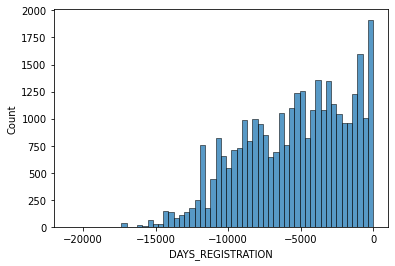

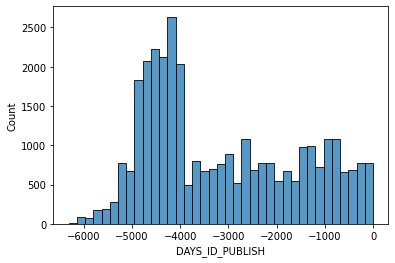

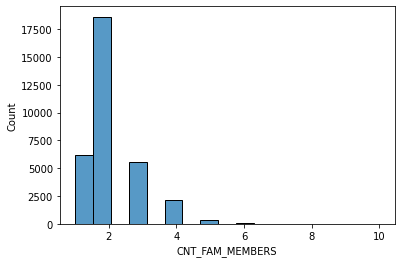

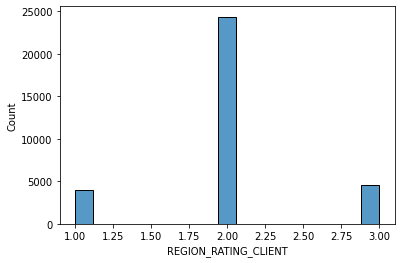

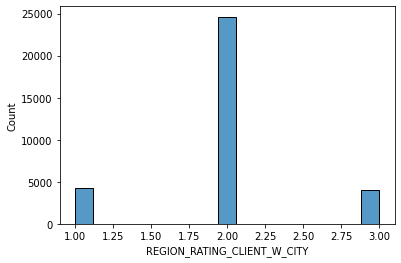

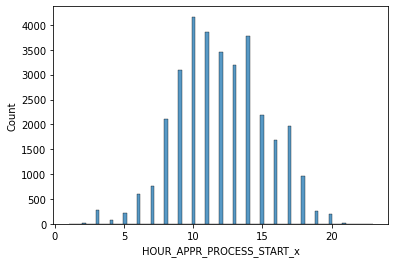

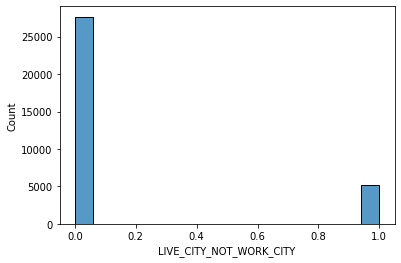

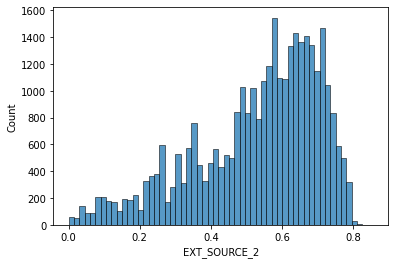

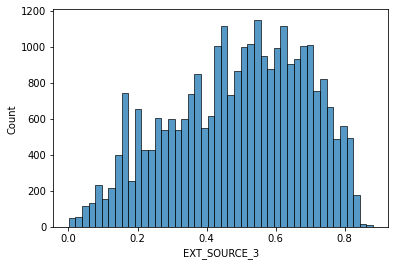

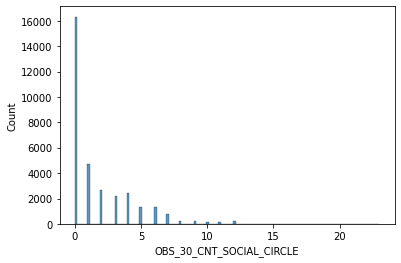

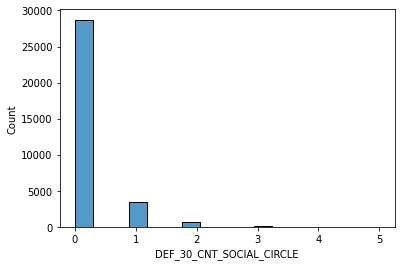

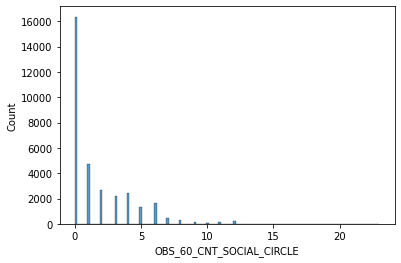

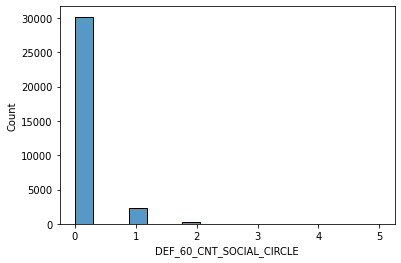

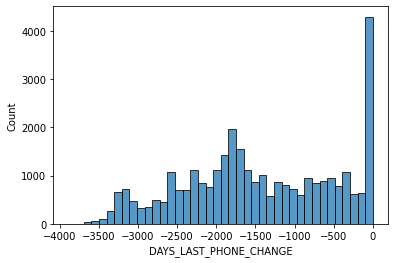

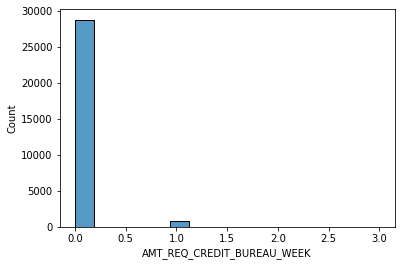

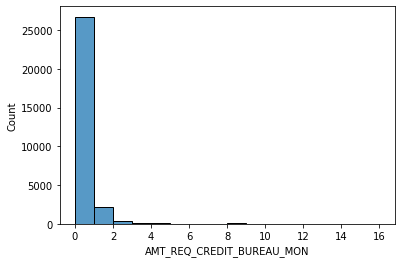

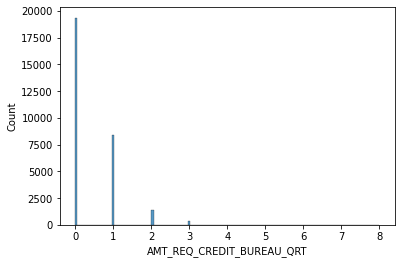

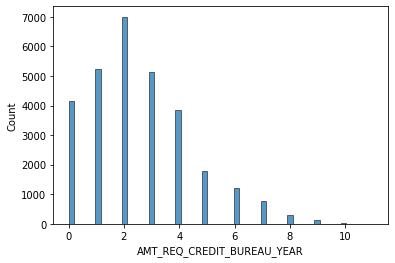

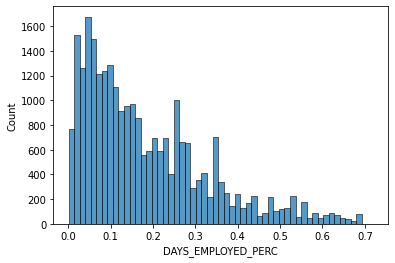

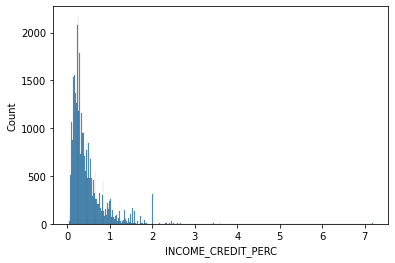

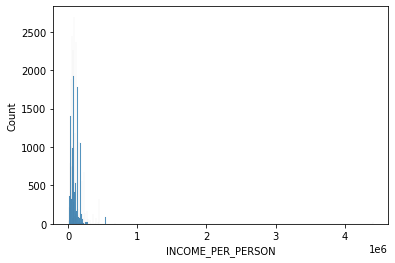

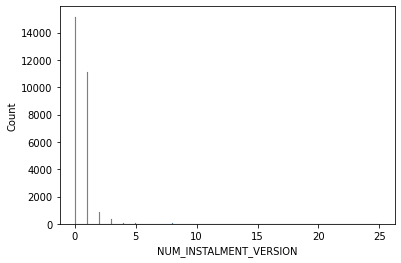

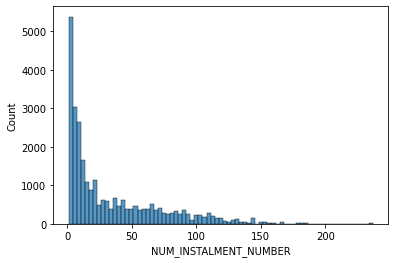

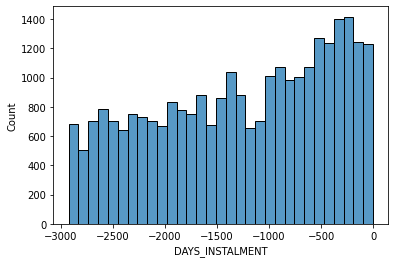

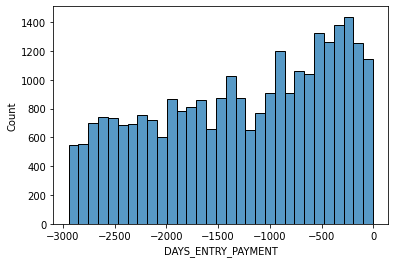

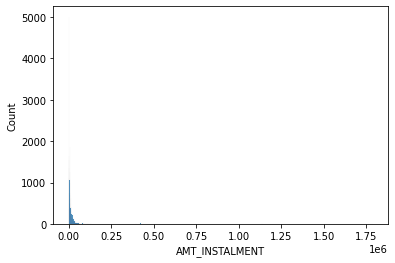

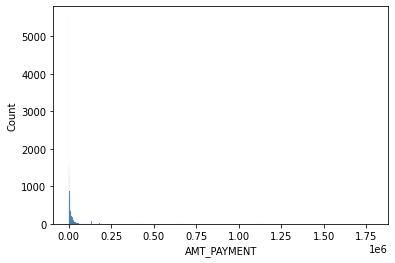

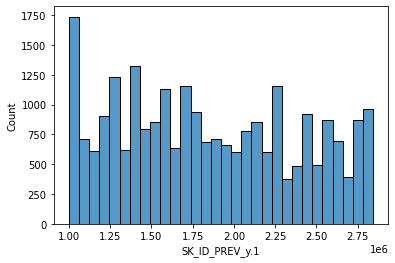

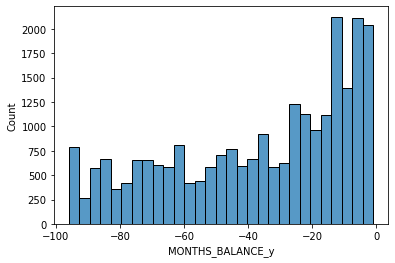

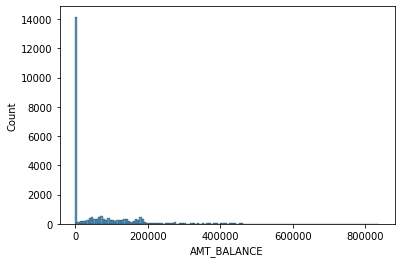

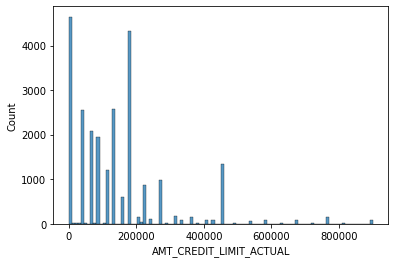

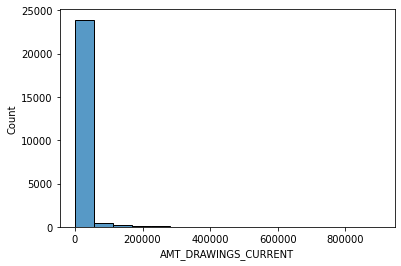

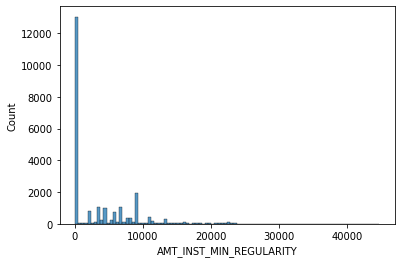

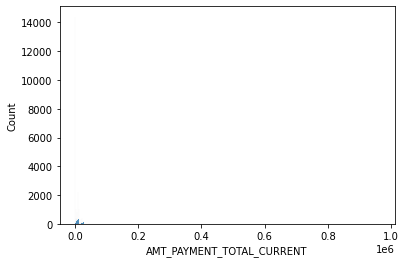

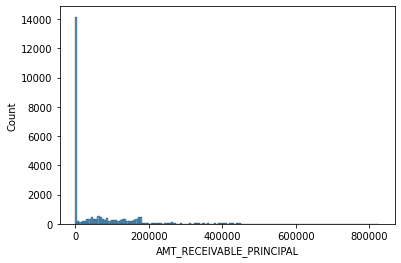

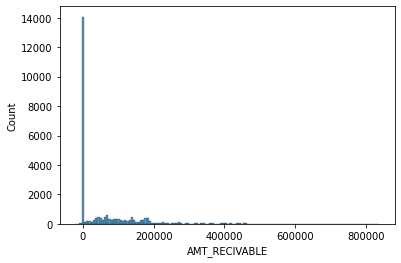

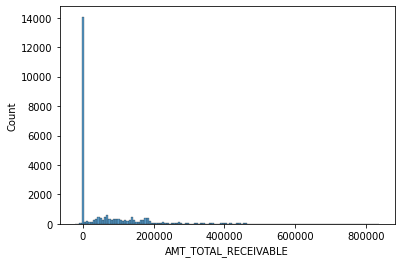

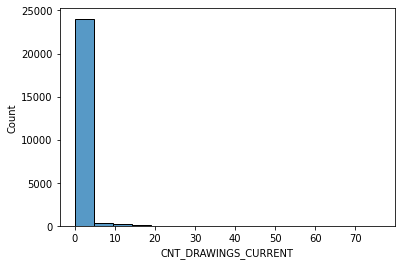

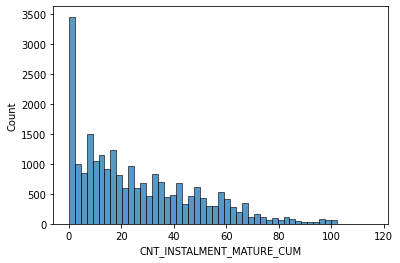

In [ ]:
for col in num_col:
  sns.histplot(data=numerical_df,x=col)
  plt.show()

# Handle missing values

In [ ]:
data[cat_col] = data[]
print(len(data),len(data.dropna()))

32902 6934


In [ ]:
data.isnull().sum()/len(data)

NAME_CONTRACT_TYPE_x         0.000000
NAME_TYPE_SUITE_x            0.012431
NAME_INCOME_TYPE             0.000030
NAME_EDUCATION_TYPE          0.000030
NAME_FAMILY_STATUS           0.000030
                               ...   
AMT_RECIVABLE                0.246763
AMT_TOTAL_RECEIVABLE         0.246763
CNT_DRAWINGS_CURRENT         0.246763
CNT_INSTALMENT_MATURE_CUM    0.273844
TARGET                       0.552580
Length: 74, dtype: float64